In [1]:
import pandas as pd
import QuantLib as ql
import datetime as dt
import matplotlib.pyplot as plt

In [2]:
aggregate_schedules = pd.read_csv("MBONOschedules.csv", parse_dates = ['Date'], index_col=0)

In [3]:
price_snapshot = pd.read_csv("MBONOsnapshot.csv", index_col = 0)

In [4]:
#val_date = ql.Date(16,11,2022)
val_date = ql.Date.todaysDate()
ql.Settings.instance().evaluationDate = val_date
convention = ql.Unadjusted
calendar = ql.Mexico()
tenor = ql.Period(ql.Semiannual)
rule = ql.DateGeneration.Backward
day_count = ql.Actual360()
settlement_days = 2

In [5]:
for b in price_snapshot.index:
    bond_schedule = aggregate_schedules[aggregate_schedules['BBG Id'] == b].copy().sort_values('Date')
    bond_schedule['Days'] = (bond_schedule['Date'] - bond_schedule['Date'].shift(1)).dt.days
    schedule = ql.Schedule(bond_schedule['Date'].apply(ql.Date().from_date).values, calendar, 
                           convention, convention, tenor, rule, False)
    face_value = sum(bond_schedule['Principal'])
    coupons = ((360 / bond_schedule['Days']) * bond_schedule['Coupon'] / face_value).dropna().values
    bond = ql.FixedRateBond(settlement_days, 100, schedule, coupons, day_count)
    price_snapshot.loc[b, 'Yield'] = bond.bondYield(price_snapshot.loc[b, 'Price'],
                                                    day_count, ql.Compounded, ql.Semiannual)
    price_snapshot.loc[b, 'QL bond'] = bond

In [6]:
bond_helpers = [ql.BondHelper(ql.QuoteHandle(ql.SimpleQuote(
    price_snapshot.loc[b, 'Price'])), price_snapshot.loc[b, 'QL bond']) 
                for b in price_snapshot.index]

In [7]:
yield_curve = ql.PiecewiseLogCubicDiscount(val_date, bond_helpers, day_count)
curve_fitting = ql.SvenssonFitting()
yield_curve_fit = ql.FittedBondDiscountCurve(settlement_days, calendar, bond_helpers, day_count, curve_fitting)

In [8]:
disc_curve_handle = ql.YieldTermStructureHandle(yield_curve_fit)
bond_engine = ql.DiscountingBondEngine(disc_curve_handle)
for b in price_snapshot.index:
    price_snapshot.loc[b, 'QL bond'].setPricingEngine(bond_engine)
    price_snapshot.loc[b, 'Th Price'] = price_snapshot.loc[b, 'QL bond'].NPV() - \
    price_snapshot.loc[b, 'QL bond'].accruedAmount()
    price_snapshot.loc[b, 'Th Yield'] = price_snapshot.loc[b, 'QL bond'].bondYield(price_snapshot.loc[b, 'Th Price'],
                                                                                  day_count, ql.Compounded,
                                                                                  ql.Semiannual)

In [9]:
price_snapshot

,Price,Yield,QL bond,Th Price,Th Yield
BBG Id,,,,,
ED2028832 Corp,97.684,0.104568,<QuantLib.QuantLib.FixedRateBond; proxy of <Sw...,97.824876,0.103047
ED7791103 Corp,100.556,0.096880,<QuantLib.QuantLib.FixedRateBond; proxy of <Sw...,100.399774,0.097745
EF7918115 Corp,106.260,0.091978,<QuantLib.QuantLib.FixedRateBond; proxy of <Sw...,105.993906,0.092304
EG1116375 Corp,94.171,0.090890,<QuantLib.QuantLib.FixedRateBond; proxy of <Sw...,93.886169,0.091698
EH6834517 Corp,96.979,0.091184,<QuantLib.QuantLib.FixedRateBond; proxy of <Sw...,97.175908,0.090773
EH6944449 Corp,93.577,0.092718,<QuantLib.QuantLib.FixedRateBond; proxy of <Sw...,93.665638,0.092606
EI8047355 Corp,91.767,0.091515,<QuantLib.QuantLib.FixedRateBond; proxy of <Sw...,92.080846,0.090951
EJ1291206 Corp,86.084,0.092852,<QuantLib.QuantLib.FixedRateBond; proxy of <Sw...,86.127752,0.092798
EK1693424 Corp,89.629,0.091827,<QuantLib.QuantLib.FixedRateBond; proxy of <Sw...,89.558642,0.091932


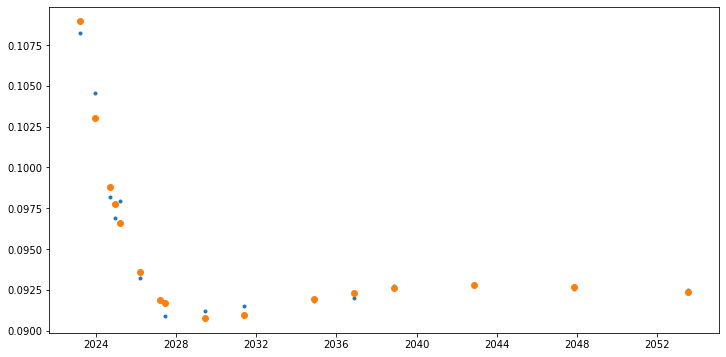

In [10]:
price_snapshot
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1,1,1)
ax.plot_date([ql.BondFunctions.maturityDate(b).to_date() for b in price_snapshot['QL bond']], 
             price_snapshot['Yield'], '.')
ax.plot_date([ql.BondFunctions.maturityDate(b).to_date() for b in price_snapshot['QL bond']], 
             price_snapshot['Th Yield'], 'o')
plt.show()

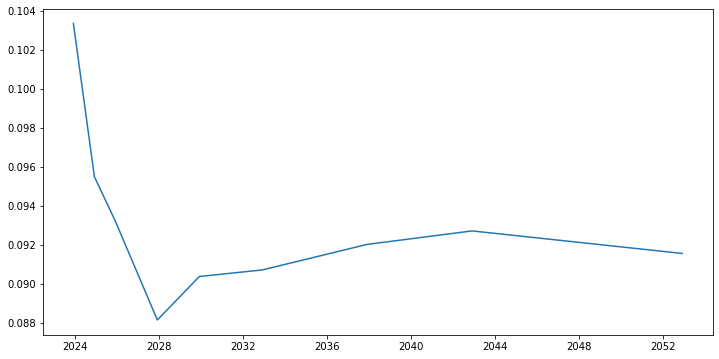

In [11]:
ref_date = yield_curve.referenceDate()
sample_dates = [ref_date + ql.Period(i, ql.Years) for i in [1,2,3,5,7,10,15,20,30]]
sample_rates = [yield_curve.zeroRate(d, ql.Actual365Fixed(), ql.Continuous).rate() for d in sample_dates]
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1,1,1)
ax.plot_date([d.to_date() for d in sample_dates], sample_rates, '-')
plt.show()

In [12]:
price_snapshot['Yield'] - price_snapshot['Th Yield']

BBG Id
ED2028832 Corp    0.001616
ED7791103 Corp   -0.000829
EF7918115 Corp   -0.000318
EG1116375 Corp   -0.000836
EH6834517 Corp    0.000422
EH6944449 Corp    0.000103
EI8047355 Corp    0.000594
EJ1291206 Corp    0.000029
EK1693424 Corp   -0.000084
QJ1649335 Corp   -0.000445
AM7523740 Corp   -0.000109
AX6352725 Corp   -0.000584
ZR8833868 Corp   -0.000753
BR4592233 Corp   -0.000031
BS4948482 Corp    0.001325
BX4963407 Corp    0.000123
dtype: float64